## 3. Generating gaits

The next step in developing the robot kinematics is to generate various gaits. First, lets familiarize ourselves with the concept of gaits. Gait is a coordinated sequence of movements of the robot legs and body to achieve smooth locomotion.

The gait cycle of a hexapod robot refers to the sequential movement of its six legs to achieve locomotion. It consists of two main phases for each leg:

 1. Stance Phase – The leg is in contact with the ground, providing support and propulsion as it moves backward relative to the body.
 2. Swing Phase – The leg lifts off the ground, moves forward, and prepares for the next stance phase.

To get an idea of the variance and complexity between gaits, Fig 1. shows four typical gaits. The six legs, right and left hind, middle and front, indicated as RH, RM, RF, LH, LM, and LF, at any one time are either on the ground pushing forward (supporting) shown in white, or in the air moving up to their next position (recovering) shown in black. [borrowed from hexapodrobot.weebly.com](https://hexapodrobot.weebly.com/the-legs.html)

<div>
<img src="hexapod_gaits.png" width="600"/>
</div>

Fig 1. Four typical hexapodal gaits, depicting each of the six legs as either supporting (white) or recovering (black). Image source: (Chen et al. 2012)

The two most common gaits for hexapods are the tripod gait and the ripple gait. The tripod gait is a simple gait where the robot legs move in two groups of three, lifting one group of three legs at a time. While the ripple gait is a more complex gait where the legs move in a wave-like motion, lifting one leg at a time.

## Tripod gait

The tripod gait is a simple gait where the robot legs move in two groups of three:
 - group A: left-front, right-middle, and left-back
 - group B: right-front, left-middle, and right-back.

while one group is in stance phase, the other group is in swing phase and cycle repeats.

Lets build the simplest tripod gait generator, it will generate offsets for each leg at a specific phase (0.0 to 1.0).

In [ ]:
# For local development enable python modules live reloading
%load_ext autoreload
%autoreload 2

All cell outputs in this notebook are stripped from source code. To see the outputs, run the notebook locally or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dr-QP/Dr.QP/blob/main/notebooks/3_generating_gaits.ipynb)

### Note for non default branch

If you are viewing non default branch change `--branch=main` below to branch name you are viewing.

### Runtime restart!!

The runtime need to be restarted to pick up the new modules. The code below will install them and kill runtime, simply run all cells again afterwards

In [ ]:
# type: ignore
# Setup for Google Colab
import importlib.util

IN_COLAB = (
    importlib.util.find_spec('google') is not None
    and importlib.util.find_spec('google.colab') is not None
)

if IN_COLAB:
    try:
        import plotting  # noqa: F401
        import point  # noqa: F401
    except ImportError:
        !git clone --filter=blob:none --no-checkout --depth 1 --sparse https://github.com/Dr-QP/Dr.QP.git --branch=main
        !cd Dr.QP && git sparse-checkout add notebooks && git checkout && cd ..
        !mv Dr.QP/notebooks/* .
        !mv Dr.QP/* .
        !rm -rf Dr.QP
        %pip install -r requirements.txt
        print('\n\n\nRestarting runtime to pick up the new modules...')
        import os

        os.kill(os.getpid(), 9)

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt

plt.ioff()  # this is equivalent to using inline backend, but figures have to be displayed manually

In [ ]:
from gait_generators import GaitGenerator
import matplotlib.pyplot as plt
from models import HexapodLeg
import numpy as np
from point import Point3D


class TripodGaitGenerator(GaitGenerator):
    def __init__(
        self,
        step_length=50,  # Length of each step in meters
        step_height=40,  # Height of leg lift in meters
    ):
        """
        Tripod gait generator for hexapod robot.

        Generates leg tip offsets in right-hand coordinate system (x-forward, y-left, z-up).

        Parameters:
        -----------
            step_length: Length of each step in meters
            step_height: Height of leg lift in meters

        """
        # Store parameters as member fields
        self.step_length = step_length
        self.step_height = step_height

        # Define leg groups for tripod gait
        self.tripod_a = [HexapodLeg.left_front, HexapodLeg.right_middle, HexapodLeg.left_back]
        self.tripod_b = [HexapodLeg.right_front, HexapodLeg.left_middle, HexapodLeg.right_back]
        super().__init__()

    def get_offsets_at_phase(self, phase) -> dict[str, Point3D]:
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Dictionary of leg positions with their corresponding offsets

        """
        # Generate offsets for each leg group
        offsets = {}

        # Tripod A legs
        a_offset = self._calculate_leg_offset(phase)
        for leg in self.tripod_a:
            offsets[leg] = a_offset

        # Tripod B legs (half cycle offset)
        b_offset = self._calculate_leg_offset(phase + 0.5)
        for leg in self.tripod_b:
            offsets[leg] = b_offset

        return offsets

    def get_offsets_at_phase_for_leg(self, leg, phase) -> Point3D:
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Offset for the specified leg

        """
        # Tripod B legs (half cycle offset)
        if leg in self.tripod_b:
            phase += 0.5

        return self._calculate_leg_offset(phase)

    def _calculate_leg_offset(self, phase):
        """Calculate offset for a single leg at phase."""
        # Ensure phase is between 0 and 1
        phase = phase % 1.0

        # Convert phase to angle (0 to 2π)
        t = phase * 2 * np.pi

        # X movement: forward during swing phase, backward during stance phase
        x_offset = -self.step_length / 2 * np.cos(t)

        # Z movement: up during swing phase, down during stance phase
        z_offset = 0
        if np.sin(t) > 0:  # Only lift during swing phase
            z_offset = self.step_height * np.sin(t)

        # Y offset is always zero for straight walking
        y_offset = 0

        return Point3D([x_offset, y_offset, z_offset])


# Example usage
gait_generator = TripodGaitGenerator()

# Visualize the continuous gait
gait_generator.visualize_continuous(_steps=100)

_ = gait_generator.visualize_continuous_in_3d(_steps=100)

In [ ]:
from models import HexapodModel
from plotting import animate_plot, plot_hexapod, update_hexapod_plot


def animate_hexapod_gait(
    hexapod: HexapodModel,
    gaits_gen: GaitGenerator,
    interactive=False,
    skip=False,
    total_steps=60,
    interval=16,
    view_elev=47.0,
    view_azim=-160,
    repeat=1,
    feet_trails_frames=0,
):
    if skip:
        return
    leg_centers = {leg.label: leg.tibia_end.copy() for leg in hexapod.legs}
    leg_tips = [leg.tibia_end.copy() for leg in hexapod.legs]

    def set_pose(step):
        step = step % total_steps  # handle repeats
        phase = step / total_steps  # interpolation phase
        for leg, leg_tip in zip(hexapod.legs, leg_tips):
            offsets = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase)
            leg.move_to(leg_tip + offsets)

    fig, ax, plot_data = plot_hexapod(hexapod, feet_trails_frames=feet_trails_frames)
    ax.view_init(elev=view_elev, azim=view_azim)

    gaits_gen.visualize_continuous_in_3d(
        _steps=total_steps, ax=ax, plot_lines=None, leg_centers=leg_centers
    )

    def update(frame=0):
        set_pose(frame)
        update_hexapod_plot(hexapod, plot_data)
        fig.canvas.draw_idle()

    animate_plot(
        fig,
        update,
        _interactive=interactive,
        _frames=total_steps * repeat,
        _interval=interval,
    )


hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)
generator = TripodGaitGenerator(step_length=120)

anim = animate_hexapod_gait(hexapod, generator, interactive=True, skip=False)

This gives a nice forward locomotive gait. However some changes are needed to the generated gait. Right now it starts with legs on the ground, but with maxed out X offsets. To mitigate this we need to introduce a transition stage that will take legs from whatever position they are in to the starting position.

A good starting point for the transition is a 0.25 phase mark where all legs have zero offsets in X axis, however group A is lifted up. In order to start from all the legs on the ground we need to compress Z phase to quarter of the original cycle.

So here is the plan for transition stage: 
 1. It runs for 0.25 of the phase
 2. We start with X cycle at 0.25 
 3. We start Z cycle 0, but compress first 0.5 of it to 0.25. 
 4. At 0.5 both cycles sync up and cycle continues till 1.0
 5. Then we start the full cycle.

Transition out of gait is similar, but starts at 0 and ends at 0.25 or X and Z cycles is compressed to 0.25.

Below is the implementation of the transition. This kind of code works for the animation and is suitable for tripod gait, but with increase of gait complexity and with joystick style controls it would be impossible to implement it this way. We are going to explore a different approach later in this notebook.

In [ ]:
def animate_hexapod_gait_with_transitions(
    hexapod: HexapodModel,
    gaits_gen: GaitGenerator,
    interactive=False,
    skip=False,
    total_steps=60,
    interval=16,
    view_elev=7.0,
    view_azim=-112,
    repeat=2,
):
    if skip:
        return
    transition_time_in = 0.75
    transition_steps_in = int(total_steps * transition_time_in)
    transition_steps_intro = int(total_steps * 0.25)
    transition_steps_rest = int(transition_steps_in - transition_steps_intro)

    phase_in_x_steps = np.concatenate(
        (
            np.linspace(0.25, 0.5, transition_steps_intro),
            np.linspace(0.5, 1.0, transition_steps_rest),
        )
    )
    phase_in_z_steps = np.concatenate(
        (
            np.linspace(0.0, 0.5, transition_steps_intro),
            np.linspace(0.5, 1.0, transition_steps_rest),
        )
    )

    transition_time_out = 0.25
    transition_steps_out = int(total_steps * transition_time_out)
    phase_out_x_steps = np.linspace(0.0, 0.25, transition_steps_out + 1)
    phase_out_z_steps = np.linspace(0.0, 0.5, transition_steps_out + 1)

    transition_steps_end = total_steps * repeat + transition_steps_in

    total_frames = total_steps * repeat + transition_steps_in + transition_steps_out

    leg_tips = [leg.tibia_end.copy() for leg in hexapod.legs]

    def set_pose(step):
        if step < transition_steps_in:
            phase_x = phase_in_x_steps[step]
            phase_z = phase_in_z_steps[step]

            offsets = {}
            for leg in hexapod.legs:
                off = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase_x)
                offsets[leg.label] = Point3D([off.x, 0, 0])

            for leg in hexapod.legs:
                off = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase_z)
                offsets[leg.label] += Point3D([0, 0, off.z])

            for leg, leg_tip in zip(hexapod.legs, leg_tips):
                leg.move_to(leg_tip + offsets[leg.label])
        elif step < transition_steps_end:
            step = step - transition_steps_in
            step = step % total_steps  # handle repeats
            phase = step / total_steps  # interpolation phase
            for leg, leg_tip in zip(hexapod.legs, leg_tips):
                offsets = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase)
                leg.move_to(leg_tip + offsets)

        else:
            end_step = step - transition_steps_end
            phase_x = phase_out_x_steps[end_step]
            phase_z = phase_out_z_steps[end_step]

            offsets = {}
            for leg in hexapod.legs:
                off = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase_x)
                offsets[leg.label] = Point3D([off.x, 0, 0])

            for leg in hexapod.legs:
                off = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase_z)
                offsets[leg.label] += Point3D([0, 0, off.z])

            for leg, leg_tip in zip(hexapod.legs, leg_tips):
                leg.move_to(leg_tip + offsets[leg.label])

    fig, ax, plot_data = plot_hexapod(hexapod)
    ax.view_init(elev=view_elev, azim=view_azim)

    def update(frame=0):
        set_pose(frame)
        update_hexapod_plot(hexapod, plot_data)
        fig.canvas.draw_idle()

    animate_plot(
        fig,
        update,
        _interactive=interactive,
        _frames=total_frames,
        _interval=interval,
    )


hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)
walk_controller = TripodGaitGenerator(step_length=120)

anim = animate_hexapod_gait_with_transitions(
    hexapod, walk_controller, interactive=True, skip=False, view_elev=25
)

This gives a nice forward locomotive gait. However it is forward only and there is no control over the direction of the movement. It is possible to move backwards by reversing the phase interpolation, but it would be nice to be able to control direction using the vector. This way this gait generator can be used with real robot and joystick control.

## Directional Gait Decorator

In order to add direction to the generated gait, we can create a decorator class that will take the generated offsets and apply a rotation to them. This way we can control the direction of the movement.

### TL;DR

We need a 2D rotation matrix that aligns the offsets (originally along the X-axis) with an arbitrary direction vector $[dx, dy]$. The rotation matrix that achieves this is:

\begin{equation}
\begin{bmatrix}
dx & -dy\\
dy & dx
\end{bmatrix}
\end{equation}

### Why This Works

 - Original offsets are along the X-axis, meaning they can be represented as $[x, 0]$.
 - A A standard 2D rotation matrix for an angle $\theta$ is:


\begin{equation}
R=\begin{bmatrix}
\cos\theta & -\sin\theta\\
\sin\theta & \cos\theta
\end{bmatrix}
\end{equation}

 - The unit direction vector $[dx, dy]$ corresponds to the cosine and sine of some angle, where:

\begin{equation}
\begin{aligned}
dx = \cos\theta\\
dy = \sin\theta
\end{aligned}
\end{equation}

 - Substituting these into the rotation matrix gives us the desired transformation matrix.
 
\begin{equation}
R=\begin{bmatrix}
dx & -dy\\
dy & dx
\end{bmatrix}
\end{equation}

In [ ]:
from transforms import Transform


class DirectionalGaitGenerator(GaitGenerator):
    """Gait generator decorator to allow steering in any direction."""

    def __init__(self, decorated: GaitGenerator):
        super().__init__()
        self.decorated = decorated

    def get_offsets_at_phase(self, phase, direction=Point3D([1, 0, 0])) -> dict[str, Point3D]:
        tf = self.__make_transform(direction)
        offsets = self.decorated.get_offsets_at_phase(phase)
        return {leg: tf.apply_point(offsets[leg]) for leg in offsets}

    def get_offsets_at_phase_for_leg(self, leg, phase, direction=Point3D([1, 0, 0])) -> Point3D:
        tf = self.__make_transform(direction)
        offsets = self.decorated.get_offsets_at_phase_for_leg(leg, phase)
        return tf.apply_point(offsets)

    @staticmethod
    def __make_transform(direction):
        # Normalize direction vector
        norm_direction = direction.normalized().numpy()

        # Create rotation matrix to align direction with x-axis
        # Ignore z-component as robot can't walk up. This also allows to generate steering in place
        direction_transform = Transform.from_rotmatrix(
            [
                [norm_direction[0], -norm_direction[1], 0],
                [norm_direction[1], norm_direction[0], 0],
                [0, 0, 1],
            ]
        )
        return direction_transform

    def _legend_for_leg(self, leg) -> str:
        return self.decorated._legend_for_leg(leg)

    def _line_style_for_leg(self, leg) -> str:
        return self.decorated._line_style_for_leg(leg)


# Example usage
directional_tripod_gen = DirectionalGaitGenerator(TripodGaitGenerator(step_length=120))

directional_tripod_gen.visualize_continuous_in_3d(direction=Point3D([1, 0, 0], 'Forward'))
directional_tripod_gen.visualize_continuous_in_3d(direction=Point3D([0, 1, 0], 'Left'))
directional_tripod_gen.visualize_continuous_in_3d(direction=Point3D([1, 1, 0], 'Forward-Left'))

# stomp in place
_ = directional_tripod_gen.visualize_continuous_in_3d(direction=Point3D([0, 0, 1], 'UP/Stomp'))

Adding a direction vector did the trick, at least charts look good. Let's see it on the hexapod.

In [ ]:
def animate_hexapod_gait_with_direction(
    hexapod: HexapodModel,
    gaits_gen: GaitGenerator,
    interactive=False,
    animate_trajectory=False,
    skip=False,
    total_steps=60,
    interval=16,
    view_elev=10.0,
    view_azim=-112,
    repeat=1,
    gait_lines=None,
    direction_degrees=0,
    animate_direction_degrees=False,
    direction_vector_length=100,
    trajectory_animation_start=0,
    trajectory_animation_end=1,
    feet_trails_frames=0,
):
    if skip:
        return

    leg_tips = [leg.tibia_end.copy() for leg in hexapod.legs]
    leg_centers = {leg.label: leg.tibia_end.copy() for leg in hexapod.legs}

    def set_pose(step, direction):
        step = step % total_steps  # handle repeats
        phase = step / total_steps  # interpolation phase
        for leg, leg_tip in zip(hexapod.legs, leg_tips):
            offsets = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase, direction=direction)
            leg.move_to(leg_tip + offsets)

    fig, ax, plot_data = plot_hexapod(hexapod, feet_trails_frames=feet_trails_frames)
    ax.view_init(elev=view_elev, azim=view_azim)
    dir_plot = ax.plot([0, direction_vector_length], [0, 0], [0, 0], 'y--')

    if animate_trajectory:
        trajectory_animation_end = 0
    _, gait_lines = gaits_gen.visualize_continuous_in_3d(
        _steps=total_steps,
        ax=ax,
        phase_start=trajectory_animation_start,
        phase_end=trajectory_animation_end,
        plot_lines=None,
        leg_centers=leg_centers,
    )

    def update(frame=0, direction_degrees=direction_degrees):
        if animate_direction_degrees:
            direction_degrees = (frame / (total_steps * repeat)) * 360
        direction = Transform.from_rotvec([0, 0, direction_degrees], degrees=True).apply_point(
            Point3D([1, 0, 0])
        )
        set_pose(frame, direction)
        update_hexapod_plot(hexapod, plot_data)
        dir_line = direction * direction_vector_length
        dir_plot[0].set_data_3d([0, dir_line.x], [0, dir_line.y], [0, dir_line.z])

        nonlocal gait_lines
        nonlocal trajectory_animation_end
        if animate_trajectory:
            step = frame % total_steps  # handle repeats
            trajectory_animation_end = step / total_steps  # interpolation phase

        _, gait_lines = gaits_gen.visualize_continuous_in_3d(
            _steps=total_steps,
            ax=ax,
            phase_start=trajectory_animation_start,
            phase_end=trajectory_animation_end,
            plot_lines=gait_lines,
            leg_centers=leg_centers,
            direction=direction,
        )
        if interactive:
            fig.canvas.draw_idle()

    animate_plot(
        fig,
        update,
        _interactive=interactive,
        _skip=skip,
        _frames=total_steps * repeat,
        _interval=interval,
        direction_degrees=(-180, 180, 1),
    )


hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)

animate_hexapod_gait_with_direction(
    hexapod,
    directional_tripod_gen,
    skip=True,  ######
    animate_trajectory=True,
    animate_direction_degrees=False,
    repeat=1,
)
animate_hexapod_gait_with_direction(
    hexapod, directional_tripod_gen, interactive=True, skip=False, animate_trajectory=True
)

That is a fully functional tripod gait generator with full steering capabilities. Time to move to the ripple gait generator.

## Ripple gait

Ripple gait is a bit more complex as it moves one leg at a time, but it looks more natural and provides more stable movement.

This RippleGaitGenerator implements a classic ripple gait where:

 1. Legs move in a 6-phase sequence
 2. Each leg is 1/6 cycle out of phase with the next leg
 3. The stance phase (on ground) is 2/3 of the cycle
 4. The swing phase (in air) is 1/3 of the cycle
 5. During stance, the leg moves backward linearly
 6. During swing, the leg lifts in a parabolic trajectory while moving forward

In [ ]:
class RippleGaitGenerator(GaitGenerator):
    def __init__(
        self,
        step_length=50,  # Length of each step in meters
        step_height=40,  # Height of leg lift in meters
    ):
        """
        Ripple gait generator for hexapod robot.

        Generates leg tip offsets in right-hand coordinate system (x-forward, y-left, z-up).

        Parameters:
        -----------
            step_length: Length of each step in meters
            step_height: Height of leg lift in meters
        """
        # Store parameters as member fields
        self.step_length = step_length
        self.step_height = step_height

        # Define leg groups for ripple gait (6-phase)
        self.leg_sequence = [
            HexapodLeg.left_back,
            HexapodLeg.right_front,
            HexapodLeg.left_middle,
            HexapodLeg.right_back,
            HexapodLeg.left_front,
            HexapodLeg.right_middle,
        ]
        super().__init__()

    def get_offsets_at_phase(self, phase) -> dict[str, Point3D]:
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Dictionary of leg positions with their corresponding offsets

        """
        offsets = {}
        for leg in self.all_legs:
            offsets[leg] = self.get_offsets_at_phase_for_leg(leg, phase)
        return offsets

    def get_offsets_at_phase_for_leg(self, leg, phase) -> Point3D:
        """
        Get offset for a specific leg at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            leg: Leg identifier string
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Offset for the specified leg

        """
        # Get leg's position in sequence (0-5)
        leg_index = self.leg_sequence.index(leg)

        # Adjust phase for this leg (each leg is 1/6 cycle offset from previous)
        leg_phase = (phase + leg_index / 6) % 1.0

        return self._calculate_leg_offset(leg_phase)

    def _calculate_leg_offset(self, phase):
        """
        Calculate the offset for a leg at a specific phase using polynomial functions for smoother motion with proper ease-in/ease-out.

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0

        Returns:
        --------
            Point3D with x, y, z offsets

        """
        # Stance phase (on ground) is 2/3 of the cycle
        stance_duration = 2 / 3

        # Swing phase (in air) is 1/3 of the cycle
        swing_duration = 1 / 3

        if phase < stance_duration:
            # Stance phase - leg on ground moving backward
            # Normalize phase to 0-1 range for stance
            stance_phase = phase / stance_duration

            # Cubic polynomial for smoother ease-in/ease-out during stance
            # f(t) = at³ + bt² + ct + d where f(0)=0.5, f(1)=-0.5, f'(0)=0, f'(1)=0
            t = stance_phase
            x_offset = self.step_length * (0.5 - (3 * t**2 - 2 * t**3))
            z_offset = 0  # On ground

        else:
            # Swing phase - leg in air moving forward
            # Normalize phase to 0-1 range for swing
            swing_phase = (phase - stance_duration) / swing_duration

            # Cubic polynomial for smoother ease-in/ease-out during swing
            # f(t) = at³ + bt² + ct + d where f(0)=-0.5, f(1)=0.5, f'(0)=0, f'(1)=0
            t = swing_phase
            x_offset = self.step_length * (-0.5 + (3 * t**2 - 2 * t**3))

            # Modified parabolic trajectory with ease-in and ease-out
            # Blend parabolic curve with ease functions at the endpoints

            # Base parabolic function (4t(1-t))
            parabola = 4 * t * (1 - t)
            # Ease-in/ease-out factor (3t² - 2t³) that's 0 at t=0 and 1 at t=1 with smooth derivatives
            ease = 3 * t * t - 2 * t * t * t
            # Scale the parabola by the ease factor to smooth the endpoints
            z_offset = self.step_height * parabola * ease

        return Point3D([x_offset, 0, z_offset])

    def _calculate_leg_offset_linear_x(self, phase):
        """
        Calculate the offset for a leg at a specific phase.

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0

        Returns:
        --------
            Point3D with x, y, z offsets

        """
        # Stance phase (on ground) is 2/3 of the cycle
        stance_duration = 2 / 3

        # Swing phase (in air) is 1/3 of the cycle
        swing_duration = 1 / 3

        if phase < stance_duration:
            # Stance phase - leg on ground moving backward
            # Normalize phase to 0-1 range for stance
            stance_phase = phase / stance_duration

            # Linear movement from front to back
            x_offset = self.step_length * (0.5 - stance_phase)
            z_offset = 0  # On ground

        else:
            # Swing phase - leg in air moving forward
            # Normalize phase to 0-1 range for swing
            swing_phase = (phase - stance_duration) / swing_duration

            # Move from back to front
            x_offset = self.step_length * (-0.5 + swing_phase)

            # Parabolic trajectory for lifting leg
            z_offset = self.step_height * 4 * swing_phase * (1 - swing_phase)

        return Point3D([x_offset, 0, z_offset])


ripple_gen = RippleGaitGenerator(step_length=120)
ripple_gen.visualize_continuous()
_ = ripple_gen.visualize_continuous_in_3d()

In [ ]:
hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)

dir_gait_gen = DirectionalGaitGenerator(ripple_gen)

anim = animate_hexapod_gait_with_direction(hexapod, dir_gait_gen, interactive=True, skip=False)

## Wave Gait

The WaveGaitGenerator implements a wave gait with these key characteristics:

 1. Only one leg is lifted at a time (maximum stability)
 2. Legs move in a wave-like sequence from back to front
 3. Each leg is 1/6 cycle out of phase with the next leg
 4. The stance phase (on ground) is 5/6 of the cycle
 5. The swing phase (in air) is only 1/6 of the cycle
 6. During stance, the leg moves backward linearly
 7. During swing, the leg lifts in a parabolic trajectory while moving forward


In [ ]:
class WaveGaitGenerator(GaitGenerator):
    def __init__(
        self,
        step_length=50,  # Length of each step in meters
        step_height=40,  # Height of leg lift in meters
    ):
        """
        Wave gait generator for hexapod robot.

        In wave gait, only one leg is lifted at a time, providing maximum stability.
        Legs move in a wave-like sequence from back to front.

        Generates leg tip offsets in right-hand coordinate system (x-forward, y-left, z-up).

        Parameters:
        -----------
            step_length: Length of each step in meters
            step_height: Height of leg lift in meters
        """
        # Store parameters as member fields
        self.step_length = step_length
        self.step_height = step_height

        # Define leg sequence for wave gait (back to front)
        self.leg_sequence = [
            HexapodLeg.right_back,
            HexapodLeg.left_back,
            HexapodLeg.right_middle,
            HexapodLeg.left_middle,
            HexapodLeg.right_front,
            HexapodLeg.left_front,
        ]
        super().__init__()

    def get_offsets_at_phase(self, phase) -> dict[str, Point3D]:
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Dictionary of leg positions with their corresponding offsets

        """
        offsets = {}
        for leg in self.all_legs:
            offsets[leg] = self.get_offsets_at_phase_for_leg(leg, phase)
        return offsets

    def get_offsets_at_phase_for_leg(self, leg, phase) -> Point3D:
        """
        Get offset for a specific leg at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            leg: Leg identifier string
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Offset for the specified leg

        """
        # Get leg's position in sequence (0-5)
        leg_index = self.leg_sequence.index(leg)

        # Adjust phase for this leg (each leg is 1/6 cycle offset from previous)
        leg_phase = (phase + leg_index / 6) % 1.0

        return self._calculate_leg_offset_poly_x(leg_phase)

    def _calculate_leg_offset_poly_x(self, phase):
        """
        Calculate the offset for a leg at a specific phase using polynomial functions for smoother motion with proper ease-in/ease-out.

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0

        Returns:
        --------
            Point3D with x, y, z offsets

        """
        # In wave gait, stance phase is 5/6 of the cycle (only 1/6 for swing)
        stance_duration = 5 / 6
        swing_duration = 1 / 6

        if phase < stance_duration:
            # Stance phase - leg on ground moving backward
            # Normalize phase to 0-1 range for stance
            stance_phase = phase / stance_duration

            # Cubic polynomial for smoother ease-in/ease-out during stance
            # f(t) = at³ + bt² + ct + d where f(0)=0.5, f(1)=-0.5, f'(0)=0, f'(1)=0
            t = stance_phase
            x_offset = self.step_length * (0.5 - (3 * t**2 - 2 * t**3))
            z_offset = 0  # On ground

        else:
            # Swing phase - leg in air moving forward
            # Normalize phase to 0-1 range for swing
            swing_phase = (phase - stance_duration) / swing_duration

            # Cubic polynomial for smoother ease-in/ease-out during swing
            # f(t) = at³ + bt² + ct + d where f(0)=-0.5, f(1)=0.5, f'(0)=0, f'(1)=0
            t = swing_phase
            x_offset = self.step_length * (-0.5 + (3 * t**2 - 2 * t**3))

            # Modified parabolic trajectory with ease-in and ease-out
            # Blend parabolic curve with ease functions at the endpoints

            # Base parabolic function (4t(1-t))
            parabola = 4 * t * (1 - t)
            # Ease-in/ease-out factor (3t² - 2t³) that's 0 at t=0 and 1 at t=1 with smooth derivatives
            ease = 3 * t * t - 2 * t * t * t
            # Scale the parabola by the ease factor to smooth the endpoints
            z_offset = self.step_height * parabola * ease

        return Point3D([x_offset, 0, z_offset])

    def _calculate_leg_offset_linear_x(self, phase):
        """
        Calculate the offset for a leg at a specific phase.

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0

        Returns:
        --------
            Point3D with x, y, z offsets

        """
        # In wave gait, stance phase is 5/6 of the cycle (only 1/6 for swing)
        stance_duration = 5 / 6
        swing_duration = 1 / 6

        if phase < stance_duration:
            # Stance phase - leg on ground moving backward
            # Normalize phase to 0-1 range for stance
            stance_phase = phase / stance_duration

            # Linear movement from front to back
            x_offset = self.step_length * (0.5 - stance_phase)
            z_offset = 0  # On ground

        else:
            # Swing phase - leg in air moving forward
            # Normalize phase to 0-1 range for swing
            swing_phase = (phase - stance_duration) / swing_duration

            # Move from back to front
            x_offset = self.step_length * (-0.5 + swing_phase)

            # Parabolic trajectory for lifting leg
            z_offset = self.step_height * 4 * swing_phase * (1 - swing_phase)

        return Point3D([x_offset, 0, z_offset])


wave_generator = WaveGaitGenerator(step_length=120, step_height=50)
wave_generator.visualize_continuous(_steps=100)
_ = wave_generator.visualize_continuous_in_3d(_steps=100)

In [ ]:
hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)

directional_wave_gen = DirectionalGaitGenerator(wave_generator)
anim = animate_hexapod_gait_with_direction(
    hexapod,
    directional_wave_gen,
    interactive=False,
    skip=True,  ######
    animate_trajectory=True,
    feet_trails_frames=20,
    animate_direction_degrees=False,
    repeat=1,
)
inter = animate_hexapod_gait_with_direction(
    hexapod, directional_wave_gen, interactive=True, skip=False
)


## Summary and steps forward (pun intended)

With the current approach we have achieved decent results and it helped us to get a basic understanding of gaits generation, however it has a serious limitations:
 1. It is not possible to transition between gaits as they are implemented as separate classes
 2. There is no transition in and out of the gait from standing position.
 3. Different gaits have different trajectories, however the only thing that has to change is the order in which legs are lifted.
 4. Phase logic is mixed with trajectory logic.

Lets rework the code to address all these issues and have production ready solution we will use in the next notebook that will be taking all we have learned so far to real ROS implementation controlling a simulated robot in Gazebo.

Our new approach should satisfy the following requirements:
 1. Allow defining a gait trajectory.
 2. Allow defining a gait sequence.
 3. Allow defining a gait generator function that will combine the two above given a set of parameters.
 4. Allow steering, turing and transitioning between gaits and positions.

Gait trajectory are fairly straightforward and we have seen some solution using trigonometrical functions and polynomials already. Gait sequencing has been formulated mathematically before, however it can be expressed as phase offsets per leg. Each phase starts with lift and ends with push. By offsetting the leg phase we can define the sequence.

In order to achieve transitioning we need to implement trajectory interpolation. The simplest approach would be to use linear interpolation, however it may create jerkiness cause by sudden trajectory changes causing high deceleration and acceleration. Much better results can be achieved using [smoothing spline functions](https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html), e.g. a 2nd degree [B-spline](https://en.wikipedia.org/wiki/B-spline). B-spline allows a smooth transition between control points while remaining stable if some of the control points are changed, e.g. when new goal point is added. 2nd degree B-spline has continuous first derivative, which means that the velocity is smooth and has no sudden changes in direction. 



In [ ]:
from smoothing_splines import plot_spline, SplineType

frames_between_points = 30
# x, y, t
trajectory_points = np.array(
    [
        [0, 0, 0],
        [2, 1, frames_between_points * 0.5],
        [3, 1, frames_between_points * 0.75],
        [5, 2, frames_between_points * 2],
        [6, 0, frames_between_points * 5],
        [1, 4, frames_between_points * 6],
        [2, 5, frames_between_points * 7],
        [5, 3, frames_between_points * 7.5],
        [3, 3, frames_between_points * 8],
    ]
)
fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].scatter(trajectory_points[::, 0], trajectory_points[::, 1], c='k', label='Trajectory points')

current_t = trajectory_points[3, 2] + 20
plot_spline(ax[0], current_t, trajectory_points, k=1)
spline_x, spline_y = plot_spline(
    ax[0],
    current_t,
    trajectory_points,
    k=3,
    derivatives=4,
    derivatives_ax=ax[1],
    bc_type='natural',
    spline_type=SplineType.interp,
    color='green',
)

for x, y, t in trajectory_points:
    ax[0].text(x, y + 0.2, f'{t=}')

ax[0].text(spline_x(current_t), spline_y(current_t) + 0.2, f'{current_t=}', color='green')

ax[0].legend()
ax[1].legend()

display(fig)

As you can see above, interpolating BSpline generates a smooth trajectory that follows the control points with smooth velocity changes, which will reduce strains on servos. However it comes at a cost of random overshooting that might be non desirable. 
One of the approaches is to reduce smoothness by mixing in a linear trajectory. Animation below shows how it affects the trajectory.

In [ ]:
# Animation size has reached 21028704 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
plt.rcParams['animation.embed_limit'] = 50


plt.ioff()
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

num_items = 4
max_points = 7


def update(frame=0):
    ax.clear()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Trajectory smoothing using interpolating B-spline (time points are not uniform)')
    ax.set(xlim=(-1, 10), ylim=(-1, 10), aspect='equal')
    ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

    first_point = frame // frames_between_points
    last_point = min(first_point + num_items, len(trajectory_points))
    control_points = trajectory_points[0 : last_point + 1]
    if len(control_points) > max_points:
        control_points = control_points[-max_points:]
    ##############################
    ax.scatter(trajectory_points[::, 0], trajectory_points[::, 1], c='k', label='All points')
    ax.scatter(control_points[::, 0], control_points[::, 1], c='r', label='Active points')

    for x, y, t in trajectory_points:
        ax.text(x, y + 0.2, f't={t}')

    ##############################
    # Uncomment to see other splines
    # spline_x, spline_y = plot_spline(ax, frame, control_points, 1, color='blue')
    # ax.text(spline_x(frame), spline_y(frame) + .2, f'curr_t={frame}', color='blue')

    # spline_x, spline_y = plot_spline(ax, frame, control_points, 2, color='orange')
    # ax.text(spline_x(frame), spline_y(frame) + .2, f'curr_t={frame}', color='orange')

    spline_x, spline_y = plot_spline(
        ax, frame, control_points, 3, color='green', bc_type='natural', mix=0.5
    )
    ax.text(spline_x(frame), spline_y(frame) + 0.2, f'curr_t={frame}', color='green')

    ax.legend()
    fig.canvas.draw_idle()


frames = len(trajectory_points) - 1

animate_plot(fig, update, frames * frames_between_points, _interval=16, _interactive=False)

Let's put it all together and generate some gaits!

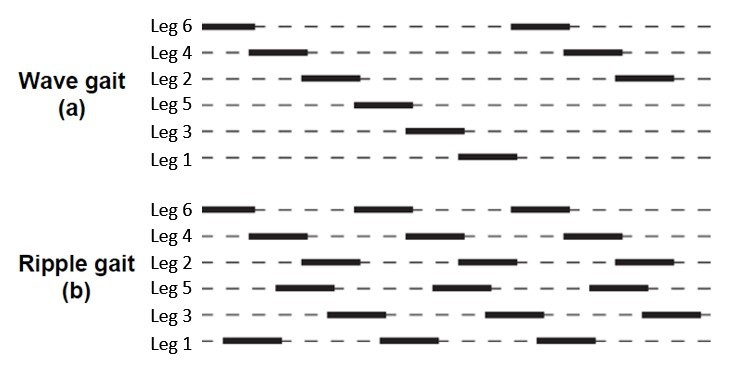

In [ ]:
%%writefile parametric_gait_generator.py
# Copyright (c) 2017-2025 Anton Matosov
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

from enum import auto, Enum

from gait_generators import GaitGenerator
from models import HexapodLeg
import numpy as np
from point import Point3D


class GaitType(Enum):
    ripple = auto()
    wave = auto()
    tripod = auto()


class ParametricGaitGenerator(GaitGenerator):
    class GaitPhaseParams:
        def __init__(
            self,
            gait_type: GaitType,
            leg_phase_offsets: dict[HexapodLeg, float],
            swing_duration: float = None,
        ):
            self.gait_type = gait_type
            self.leg_phase_offsets = leg_phase_offsets
            self.swing_duration = swing_duration

    def __init__(self, step_length=1, step_height=1, gait=GaitType.wave):
        super().__init__()

        self.step_length = step_length
        self.step_height = step_height
        self.current_gait = gait

        self.gaits = {
            GaitType.wave: self.GaitPhaseParams(
                GaitType.wave,
                leg_phase_offsets={
                    HexapodLeg.right_back: 0,
                    HexapodLeg.right_middle: 1 / 6,
                    HexapodLeg.right_front: 2 / 6,
                    HexapodLeg.left_back: 3 / 6,
                    HexapodLeg.left_middle: 4 / 6,
                    HexapodLeg.left_front: 5 / 6,
                },
                swing_duration=1 / 6,
            ),
            GaitType.ripple: self.GaitPhaseParams(
                GaitType.ripple,
                leg_phase_offsets={
                    HexapodLeg.right_back: 0,
                    HexapodLeg.right_middle: 2 / 6,
                    HexapodLeg.right_front: 4 / 6,
                    HexapodLeg.left_back: 3 / 6,
                    HexapodLeg.left_middle: 5 / 6,
                    HexapodLeg.left_front: 1 / 6,
                },
                swing_duration=1 / 3,
            ),
            GaitType.tripod: self.GaitPhaseParams(
                GaitType.tripod,
                leg_phase_offsets={
                    HexapodLeg.right_back: 0,
                    HexapodLeg.right_middle: 1 / 2,
                    HexapodLeg.right_front: 0,
                    HexapodLeg.left_back: 1 / 2,
                    HexapodLeg.left_middle: 0,
                    HexapodLeg.left_front: 1 / 2,
                },
                swing_duration=1 / 2,
            ),
        }

    def get_offsets_at_phase_for_leg(self, leg, phase) -> Point3D:
        gait = self.gaits[self.current_gait]
        leg_phase = phase - gait.leg_phase_offsets[leg]
        leg_phase %= 1

        half_step = self.step_length / 2
        if leg_phase < gait.swing_duration:
            # Swing phase - leg in air moving forward
            t = np.interp(leg_phase, [0, gait.swing_duration], [0, 1])
            x_offset = np.interp(leg_phase, [0, gait.swing_duration], [-half_step, half_step])
            z_offset = np.sin(t * np.pi) * self.step_height
        else:
            # Stance phase - leg on ground moving backward
            x_offset = np.interp(leg_phase, [gait.swing_duration, 1], [half_step, -half_step])
            z_offset = 0  # On ground

        return Point3D(
            [
                x_offset,
                0,
                z_offset,
            ]
        )


In [ ]:
import matplotlib.pyplot as plt
from parametric_gait_generator import GaitType, ParametricGaitGenerator

gait_gen = ParametricGaitGenerator()

gait_gen.current_gait = GaitType.wave
axs = gait_gen.visualize_continuous(_steps=500, _subtitle=' Wave gait')
_ = gait_gen.visualize_continuous_in_3d(_steps=100, step_length=gait_gen.step_length)

gait_gen.current_gait = GaitType.ripple
axs = gait_gen.visualize_continuous(_steps=500, _subtitle=' Ripple gait', _num_phases=3)
_ = gait_gen.visualize_continuous_in_3d(_steps=100, step_length=gait_gen.step_length)


gait_gen.current_gait = GaitType.tripod
axs = gait_gen.visualize_continuous(_steps=500, _subtitle=' Tripod gait')
_ = gait_gen.visualize_continuous_in_3d(_steps=100, step_length=gait_gen.step_length)

In [ ]:
hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)

gait_gen.step_length = 80
gait_gen.step_height = 40
gait_gen.current_gait = GaitType.ripple
dir_gait_gen = DirectionalGaitGenerator(gait_gen)

anim = animate_hexapod_gait_with_direction(
    hexapod, dir_gait_gen, interactive=True, skip=False, repeat=5
)

## Turning robot

To make robot turn we need to mix in circular movement to the gait. Let's first make it turn in place. This can be achieved by using existing gait generator and treating X offsets as a rotation angle of the foot around center of the body.

In [ ]:
from models import HexapodModel
from plotting import animate_plot


def animate_hexapod_rotation_gait(
    hexapod: HexapodModel,
    gaits_gen: GaitGenerator,
    interactive=False,
    skip=False,
    total_steps=60,
    interval=16,
    view_elev=47.0,
    view_azim=-160,
    repeat=1,
    feet_trails_frames=0,
):
    if skip:
        return
    leg_centers = {leg.label: leg.tibia_end.copy() for leg in hexapod.legs}
    leg_tips = [leg.tibia_end.copy() for leg in hexapod.legs]

    def set_pose(step):
        step = step % total_steps  # handle repeats
        phase = step / total_steps  # interpolation phase
        for leg, leg_tip in zip(hexapod.legs, leg_tips):
            offsets = gaits_gen.get_offsets_at_phase_for_leg(leg.label, phase)

            #### <<<   NEW CODE START   >>>>> #####
            rotation_transform = Transform.from_rotvec([0, 0, offsets.x], degrees=True)
            leg_tip_target = rotation_transform.apply_point(leg_tip) + Point3D([0, 0, offsets.z])
            leg.move_to(leg_tip_target)
            #### <<<   NEW CODE END     >>>>> #####

    fig, ax, plot_data = plot_hexapod(hexapod, feet_trails_frames=feet_trails_frames)
    ax.view_init(elev=view_elev, azim=view_azim)

    gaits_gen.visualize_continuous_in_3d(
        _steps=total_steps, ax=ax, plot_lines=None, leg_centers=leg_centers, rotation_gaits=True
    )

    def animate(frame=0):
        set_pose(frame)
        update_hexapod_plot(hexapod, plot_data)
        fig.canvas.draw_idle()

    animate_plot(
        fig,
        animate,
        _interactive=interactive,
        _frames=total_steps * repeat,
        _interval=interval,
    )


hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)

rotation_direction = 45  # exaggerated to see the effect
rotation_gen = ParametricGaitGenerator(step_length=rotation_direction, step_height=60)
# rotation_gen.current_gait = GaitType.tripod
# rotation_gen.current_gait = GaitType.ripple
rotation_gen.current_gait = GaitType.wave

anim = animate_hexapod_rotation_gait(hexapod, rotation_gen, interactive=False, skip=False)

### Putting it all together

Now that we have all the pieces in place, we can put them together to create a full walk controller. The controller will take care of the following:
1. Process input command of the walk direction and rotation
2. Generate a walk trajectory based on the input direction
3. Generate a turn trajectory based on the input rotation
4. Combine the two trajectories into a single walk trajectory
5. Apply the walk trajectory to the robot based on the current robot legs position

In [ ]:
%%writefile walk_controller.py
# Copyright (c) 2017-2025 Anton Matosov
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

import numpy as np
from parametric_gait_generator import GaitType, ParametricGaitGenerator
from point import Point3D
from transforms import Transform


class WalkController:
    def __init__(
        self,
        hexapod,
        step_length=60,
        step_height=40,
        rotation_speed_degrees=10,
        phase_steps_per_cycle=30,
        gait=GaitType.wave,
    ):
        self.hexapod = hexapod
        self.step_length = step_length
        self.step_height = step_height
        self.rotation_speed_degrees = rotation_speed_degrees
        self.gait_gen = ParametricGaitGenerator(step_length=1.0, step_height=1.0, gait=gait)

        self.current_phase = 0.0
        self.last_stop_phase = 0.0
        self.phase_step = 1 / phase_steps_per_cycle

        self.leg_tips_on_ground = [(leg, leg.tibia_end.copy()) for leg in hexapod.legs]

        self.current_direction = Point3D([1, 0, 0])
        self.current_stride_ratio = 0
        self.current_rotation_ratio = 0

    @property
    def current_gait(self):
        return self.gait_gen.current_gait

    @current_gait.setter
    def current_gait(self, gait):
        self.gait_gen.current_gait = gait

    def next(
        self,
        stride_direction=Point3D([1, 0, 0]),
        stride_ratio=1.0,
        rotation_ratio=0.0,
        phase_override=None,
        verbose=False,
    ):
        self.__next_phase(phase_override)
        feet_targets = self.__next_feet_targets(
            stride_direction, stride_ratio, rotation_ratio, verbose
        )
        self.__move_feet(feet_targets)

    def __next_phase(self, phase_override=None):
        if phase_override is not None:
            self.current_phase = phase_override
        else:
            self.current_phase += self.phase_step

    def __next_feet_targets(self, stride_direction, stride_ratio, rotation_ratio, verbose):
        ###############################################################
        ## All if this mixing, smoothing and clipping is a hot garbage,
        # TODO(anton-matosov) switch to proper trajectory mixing
        stride_ratio = np.clip(stride_ratio, 0, 1)
        rotation_ratio = np.clip(rotation_ratio, -1, 1)

        no_motion_eps = 0.05
        had_stride = abs(self.current_stride_ratio) > no_motion_eps
        had_rotation = abs(self.current_rotation_ratio) > no_motion_eps

        self.current_stride_ratio = np.interp(
            0.3, [0, 1], [self.current_stride_ratio, stride_ratio]
        )
        self.current_rotation_ratio = np.interp(
            0.3, [0, 1], [self.current_rotation_ratio, rotation_ratio]
        )
        self.current_direction = self.current_direction.interpolate(stride_direction, 0.3)

        self.current_stride_ratio = np.clip(self.current_stride_ratio, 0, 1)
        self.current_rotation_ratio = np.clip(self.current_rotation_ratio, -1, 1)

        has_stride = abs(self.current_stride_ratio) > no_motion_eps
        has_rotation = abs(self.current_rotation_ratio) > no_motion_eps

        had_motion = had_stride or had_rotation
        has_motion = has_stride or has_rotation

        stopping = had_motion and not has_motion
        starting = not had_motion and has_motion
        stopped = not had_motion and not has_motion

        if starting or stopped:
            self.current_phase = 0

        height_ratio = 1
        if stopping:
            self.last_stop_phase = self.current_phase
        else:
            self.last_stop_phase = 0.0
        ###############################################################

        result = []
        direction_transform = self.__make_direction_transform(self.current_direction)
        for leg, leg_tip in self.leg_tips_on_ground:
            foot_target = leg_tip
            gait_offsets = self.gait_gen.get_offsets_at_phase_for_leg(leg.label, self.current_phase)

            # Apply steering
            if has_stride:
                stride_offsets = gait_offsets * Point3D(
                    [self.step_length * self.current_stride_ratio, 0, 0]
                )
                direction_offsets = direction_transform.apply_point(stride_offsets)
                foot_target = foot_target + direction_offsets

            # Apply rotation
            if has_rotation:
                rotation_degrees = (
                    self.rotation_speed_degrees * self.current_rotation_ratio * gait_offsets.x
                )
                rotation_transform = Transform.from_rotvec([0, 0, rotation_degrees], degrees=True)
                foot_target = rotation_transform.apply_point(foot_target)

            if has_stride or has_rotation:
                foot_target.z += gait_offsets.z * self.step_height * height_ratio

            if verbose:
                print(f'{leg.label} {self.current_phase=}')
                print(f'{leg.tibia_end=}')
                print(f'{gait_offsets=}')
                print(f'{stride_offsets=}')
                print(f'{direction_offsets=}')
                print(f'{foot_target=}')
                print()
            result.append((leg, foot_target))

        return result

    @staticmethod
    def __make_direction_transform(direction):
        # Normalize direction vector
        norm_direction = direction.normalized().numpy()

        # Create rotation matrix to align direction with x-axis
        # Ignore z-component as robot can't walk up. This also allows to generate stepping in place
        direction_transform = Transform.from_rotmatrix(
            [
                [norm_direction[0], -norm_direction[1], 0],
                [norm_direction[1], norm_direction[0], 0],
                [0, 0, 1],
            ]
        )
        return direction_transform

    def __move_feet(self, legs_and_targets):
        for leg, foot_target in legs_and_targets:
            leg.move_to(foot_target)


In [ ]:
import importlib

from models import HexapodModel
from plotting import animate_plot
import walk_controller

importlib.reload(walk_controller)  # autoreload fails with files written by notebook for some reason


def animate_hexapod_walk(
    walk_controller: walk_controller.WalkController,
    interactive=False,
    skip=False,
    fps=30,
    view_elev=47.0,
    view_azim=-160,
    repeat=1,
    feet_trails_frames=0,
):
    if skip:
        return

    if interactive:
        repeat = 100

    fig, ax, plot_data = plot_hexapod(
        walk_controller.hexapod, feet_trails_frames=feet_trails_frames
    )
    ax.view_init(elev=view_elev, azim=view_azim)

    total_frames = fps * repeat

    last_frame = 0

    def animate(
        frame=0,
        direction_degrees=0,
        walk_speed=1,
        rotation_ratio=0,
    ):
        nonlocal last_frame
        if interactive and frame == last_frame:
            # other params are changing, don't update walker
            return

        phase = frame % fps
        phase = phase / fps

        if not interactive:
            walk_speed = np.interp(
                frame, [0, total_frames * 0.25, total_frames * 0.75, total_frames], [0, 1, 1, 0]
            )

        stride_direction = Point3D([1, 0, 0])
        stride_direction = Transform.from_rotvec(
            [0, 0, direction_degrees], degrees=True
        ).apply_point(stride_direction)

        walk_controller.next(
            phase_override=phase,
            stride_direction=stride_direction,
            stride_ratio=walk_speed,
            rotation_ratio=rotation_ratio,
            verbose=False,
        )
        update_hexapod_plot(hexapod, plot_data)
        fig.canvas.draw_idle()
        last_frame = frame

    animate_plot(
        fig,
        animate,
        _interactive=interactive,
        _frames=total_frames,
        _interval=1000 / fps,
        walk_speed=(0, 2, 0.1),
        direction_degrees=(-180, 180, 1),
        rotation_ratio=(-2, 2, 0.1),
    )


hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)
walker = walk_controller.WalkController(
    hexapod, step_length=120, step_height=60, rotation_speed_degrees=10, gait=GaitType.ripple
)

anim = animate_hexapod_walk(
    walker,
    interactive=True,
    skip=False,
    feet_trails_frames=40,
    repeat=5,
    view_elev=70,
    view_azim=180,
    fps=30,
)